In [141]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [2]:
## Data variable rename 
def name_ch(input_data):
    lon=input_data.dims[2]
    lat=input_data.dims[1]
    time=input_data.dims[0]
    input_data=input_data.rename({lat:'latitude'})
    input_data=input_data.rename({lon:'longitude'})
    input_data=input_data.rename({time:'time'})
    return input_data

In [3]:
def BoB_plot(input_data,title,output):
########## Data ########
    input_data=input_data.rename({input_data.dims[0]:'time'})
    datasets={}
    for i in range(1994,2019):
        summer_unfiltered=input_data.sel(time=slice(repr(i)+'-06-01',repr(i)+'-08-31')).mean(dim='time')
        datasets[i]=[]
        datasets[i].append(summer_unfiltered)
    lon=input_data[input_data.dims[2]].data
    lat=input_data[input_data.dims[1]].data
########## Info ######
    Summer_enso_info={}
    Summer_enso_info=dict({1993:None,1994:'ME, ONI:0.4',1995:'ML, ONI:-0.2',1996: None,1997:'VSE, ONI:1.6',
                        1998:'SL, ONI:-0.8',1999:'SL, ONI:-1.1',2000:'WL, ONI:-0.6',2001:None,2002:'ME, ONI:0.8',
                        2003:None,2004:'WE, ONI:0.5',2005:'WL, ONI:-0.1',2006:'WE, ONI:0.1',2007:'SL, ONI:-0.5',
                        2008:'WL, ONI:-0.4',2009:'ME, ONI:0.5',2010:'SL, ONI:-1.0',2011:'ML, ONI:-0.5',2012:None,
                        2013:None,2014:'WE, ONI:0.1',2015:'VSE, ONI:1.5',2016:'WL, ONI:-0.4',2017:'WL, ONI:0.1',
                        2018:'WE, ONI:0.1',2019:None,2020:'ML, ONI:-0.4',2021:'ML, ONI:-0.4'})

    Elnino_years=[1994,1997,2002,2004,2006,2009,2014,2015,2018]
    Lanina_years=[1995,1998,1999,2000,2005,2007,2008,2010,2011,2016,2017,2020,2021]
##########  Plotting ###########
    fig, axs = plt.subplots(nrows=5,ncols=5,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,12))
    axs=axs.flatten()
    y_label=set([0,5,10,15,20])
    x_label=set([20,21,22,23,24])
    L2=[-20,-15,-12.5,-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15,20]
    for i,year in enumerate(datasets):
            data=datasets[year]
            cs=axs[i].contourf(lon,lat,data[0],
                              levels=L2,transform = ccrs.PlateCarree(),
                              cmap='seismic',extend='both')
            axs[i].set_extent([78,100,4,25])
            axs[i].set_title(year,fontsize = 15, weight='bold')
            axs[i].coastlines()
            if i in y_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                #gl.xlines=False
            if i in x_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
            if year in Elnino_years:
                axs[i].text(88,23.5, Summer_enso_info[year],color='red', fontsize = 9,weight='bold')
            if year in Lanina_years:
                axs[i].text(88,23.5, Summer_enso_info[year],color='blue', fontsize = 9,weight='bold')

    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)
    plt.suptitle(title,fontsize = 30,weight='bold')
    plt.savefig(output,dpi=120)
    
    return 

In [4]:
def plot(input_data,title,save):
    lon=input_data[input_data.dims[1]].data
    lat=input_data[input_data.dims[0]].data
    #axs=axs.flatten()
    L2=[-.6,-.5,-.4,-.3,-.2,-.1,-.05,0,.05,.1,.2,.3,.4,.5,.6]
    fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(7,7))
    cs=axs.contourf(lon,lat,input_data,levels=L2,transform = ccrs.PlateCarree(),cmap='seismic',extend='both')
    #axs.setextent([78,100,4,25])
    #axs[1].set_title(year,fontsize = 15, weight='bold')
    axs.coastlines()
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    gl.left_labels = True
    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)

    plt.suptitle(title,fontsize = 20,weight='bold')
    plt.savefig(save,dpi=120)
    return

## Filtering code ------------------

In [13]:
import scipy.signal as signal
def butterworth_lowpass_filter(data, cutoff_time, axis=0):
    cutoff_freq=1/cutoff_time
    nyfreq=cutoff_freq*2
    order=4
    B, A = signal.butter(order, nyfreq, output="ba")
    return signal.filtfilt(B, A, data, axis=0)

# Altimeter Unfiltered

In [5]:
BoB_altimeter=xr.open_mfdataset('/home/NCAOR/supriyog/raw_data/SL_anomaly/IO_SLA_v2021.nc',autoclose=True).sel(latitude=slice(4,25),longitude=slice(78,100)).sla

In [142]:
BoB_altimeter

<xarray.DataArray 'sla' (time: 9672, latitude: 84, longitude: 88)>
dask.array<getitem, shape=(9672, 84, 88), dtype=float64, chunksize=(9672, 84, 88), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-30
  * longitude  (longitude) float32 78.12 78.38 78.62 78.88 ... 99.38 99.62 99.88
  * latitude   (latitude) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88

In [7]:
BoB_altimeter=name_ch(BoB_altimeter)

('time', 'latitude', 'longitude')


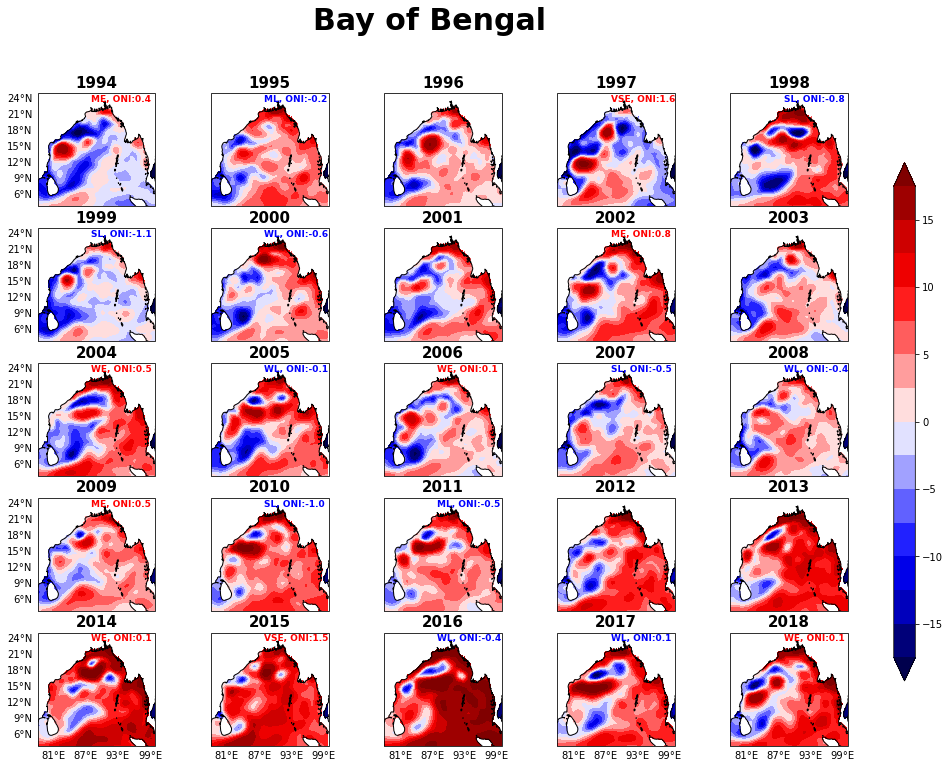

In [11]:
i=BoB_altimeter
print(i.dims)
BoB_plot(i,"Bay of Bengal",'BoB.jpg')

# LCS Unfilltered

In [566]:
BoB_lcs=xr.open_mfdataset('lcs_sla1.nc',autoclose=True
                         ).sel(time=slice('1993-01-01','2019-12-30'),lat=slice(4,25),lon=slice(78,100)).sla

In [568]:
BoB_lcs=name_ch(BoB_lcs)

('time', 'latitude', 'longitude')


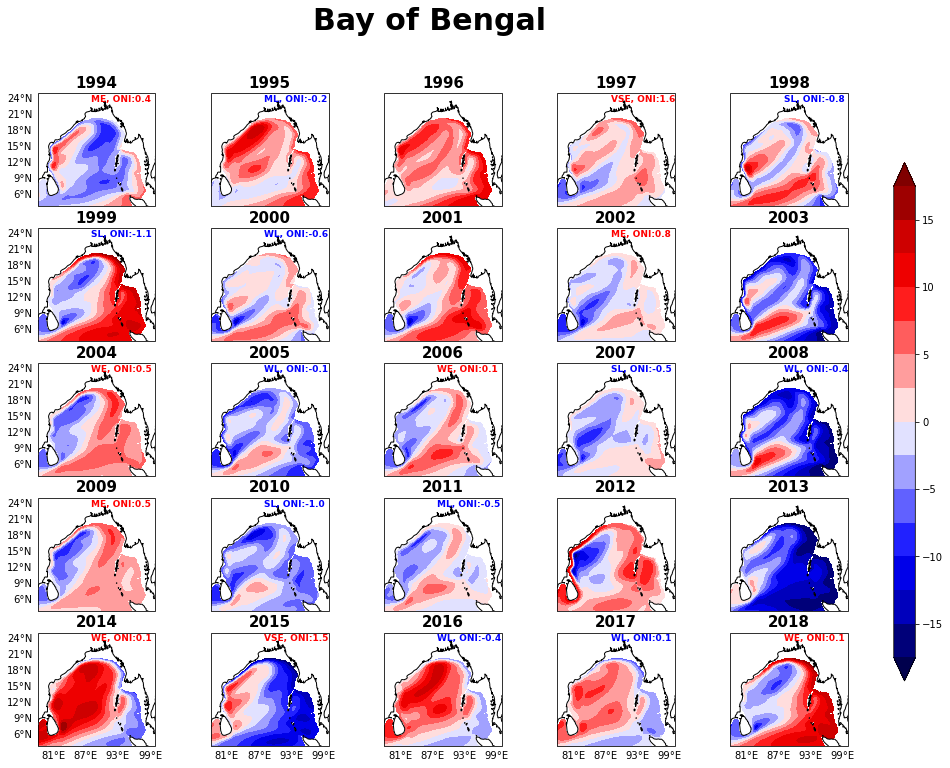

In [514]:
i=BoB_lcs
print(i.dims)
BoB_plot(i,"Bay of Bengal",'BoB.jpg')

# Altimeter Filtered

## ferret filtering

In [9]:
BoB_ferret_filtered=xr.open_mfdataset('/home/NCAOR/supriyog/raw_data/SL_anomaly/IO_SLA_v2021_low_new.nc',autoclose=True
                                     ).sel(LATITUDE=slice(4,25),LONGITUDE=slice(78,100)).SLA_LOW

In [575]:
BoB_ferret_filtered=name_ch(BoB_ferret_filtered)

('time', 'latitude', 'longitude')


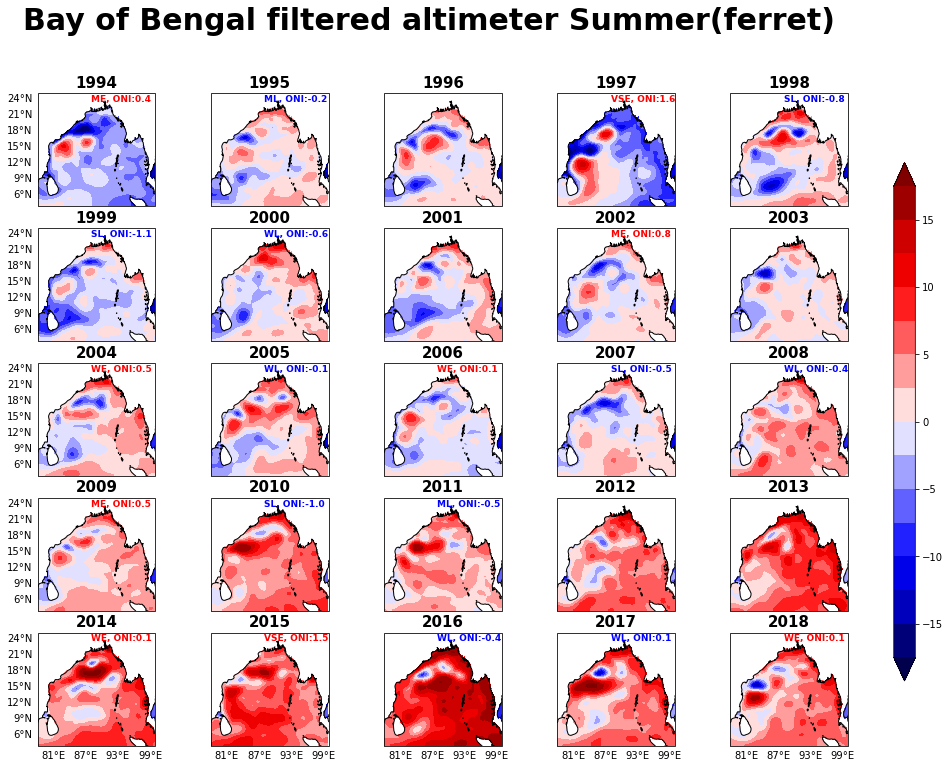

In [517]:
i=BoB_ferret_filtered
print(i.dims)
BoB_plot(i,"Bay of Bengal filtered altimeter Summer(ferret)",
         'BoB_filtered_altimeter_ferret.jpg')

## Altimeter filtering in python

In [14]:
BoB_altimeter_low = butterworth_lowpass_filter(BoB_altimeter, 400)


In [15]:
BoB_altimeter_low=xr.DataArray(BoB_altimeter_low,coords=
                                   {"time": BoB_altimeter.time, "latitude": BoB_altimeter.latitude,
                          "longitude": BoB_altimeter.longitude},
                  dims=["time", "latitude","longitude"])
BoB_altimeter_low['sla_low']=BoB_altimeter_low


('time', 'latitude', 'longitude')


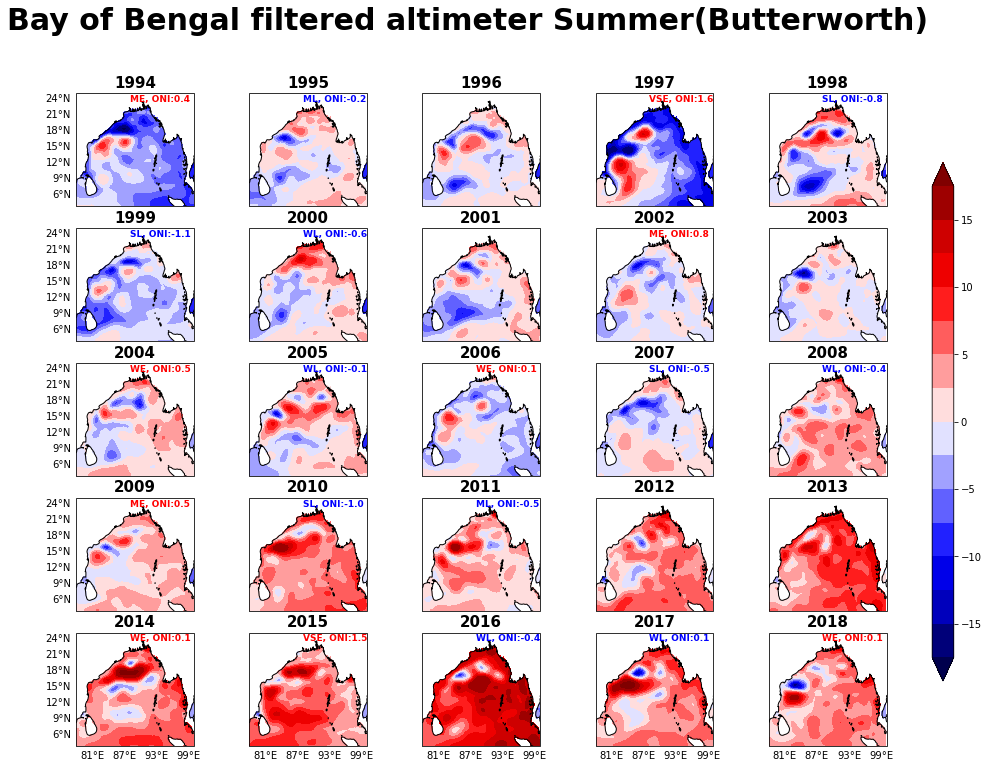

In [16]:
i=BoB_altimeter_low
print(i.dims)
BoB_plot(i,"Bay of Bengal filtered altimeter Summer(Butterworth)",
         'BoB_filtered_altimeter.jpg')

# LCS Filtered

In [578]:
BoB_lcs_low = butterworth_lowpass_filter(BoB_lcs, 400)


/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/signal/_arraytools.py:100: RuntimeWarning: invalid value encountered in subtract
  ext = np.concatenate((2 * left_end - left_ext,
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/signal/_arraytools.py:102: RuntimeWarning: invalid value encountered in subtract
  2 * right_end - right_ext),


In [579]:

BoB_lcs_low=xr.DataArray(BoB_lcs_low,coords={"time": BoB_lcs.time, "latitude": BoB_lcs.latitude,
                          "longitude": BoB_lcs.longitude},
                  dims=["time", "latitude","longitude"])

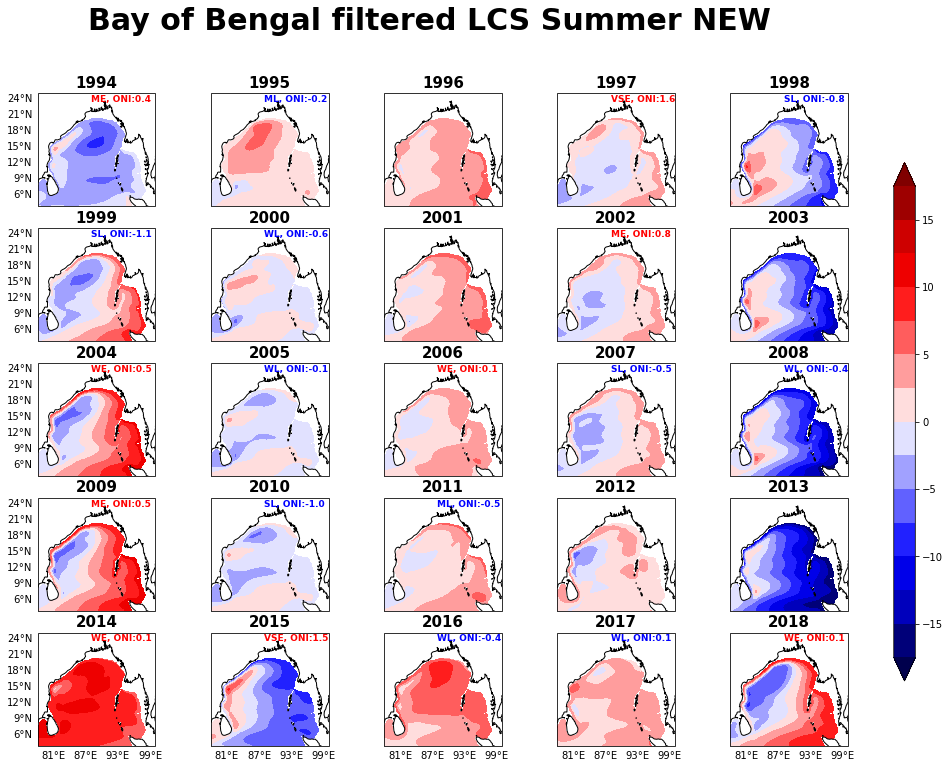

In [522]:
i=BoB_lcs_low
#print(i.dims)
BoB_plot(i,"Bay of Bengal filtered LCS Summer NEW",
         'BoB_filtered_lcs_new.jpg')

In [89]:
BoB_lcs_low_old=xr.open_mfdataset('/home/NCAOR/supriyog/.backup_files/BoB_SLA_work/BoB_plots/400dayslow_LCSCR.nc').SLA_LOW.squeeze()

In [581]:
BoB_lcs_low_old

<xarray.DataArray 'SLA_LOW' (time: 8917, latitude: 221, longitude: 221)>
dask.array<getitem, shape=(8917, 221, 221), dtype=float32, chunksize=(8917, 221, 221), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 78.0 78.1 78.2 78.3 ... 99.7 99.8 99.9 100.0
  * latitude   (latitude) float64 3.0 3.1 3.2 3.3 3.4 ... 24.7 24.8 24.9 25.0
    ZAXIS1_1   float64 0.0
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-31
Attributes:
    long_name:      LSL_LOWPASS(SLA,400,400)
    long_name_mod:  X=78E:100.1E, Y=3N:25.N, Z=0, T=31-DEC-1992 12:00:31-MAY-...
    history:        From LCSCR_SLA

In [582]:
BoB_lcs_low_old=name_ch(BoB_lcs_low_old)

('time', 'latitude', 'longitude')


/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


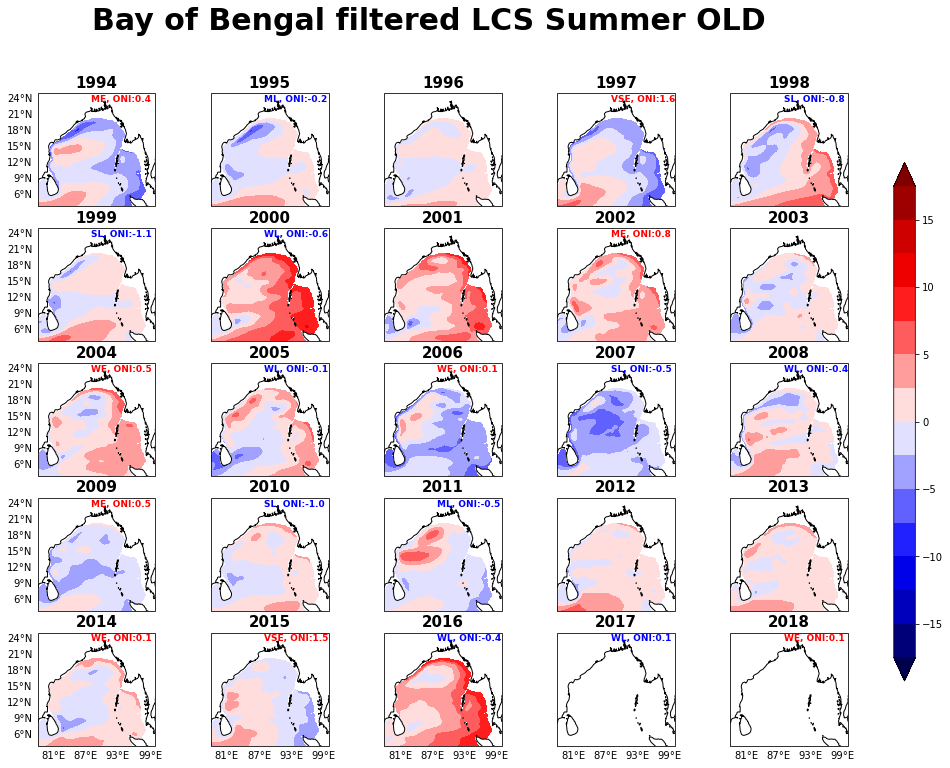

In [526]:
i=BoB_lcs_low_old
print(i.dims)
BoB_plot(i,"Bay of Bengal filtered LCS Summer OLD",
         'BoB_filtered_lcs_old.jpg')


# Correlation

In [617]:
BoB_altimeter1=BoB_altimeter.sel(time=slice('2000-01-01','2010-12-31'))
BoB_altimeter_low1=BoB_altimeter_low.sel(time=slice('2000-01-01','2010-12-31'))
BoB_lcs1=BoB_lcs.sel(time=slice('2000-01-01','2010-12-31'))
BoB_lcs_low1=BoB_lcs_low.sel(time=slice('2000-01-01','2010-12-31'))
BoB_lcs_low_old1=BoB_lcs_low_old.sel(time=slice('2000-01-01','2010-12-31'))


## Correlation of BoB Altimeter and LCS

In [610]:
## first we need to make the model data as altimeter data
BoB_lcs_inp1 = BoB_lcs1.interp_like(BoB_altimeter1)
BoB_lcs_inp1=BoB_lcs_inp.interp(latitude=BoB_altimeter1.latitude, longitude=BoB_altimeter1.longitude)



In [611]:
i=BoB_lcs_inp1
print(i.dims)
#BoB_plot(i,1,2,0,"Bay of Bengal",'test.jpg')

('time', 'latitude', 'longitude')


In [612]:
corr_altimter_lcs=xr.corr(BoB_altimeter1,BoB_lcs_inp1,dim='time')

/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


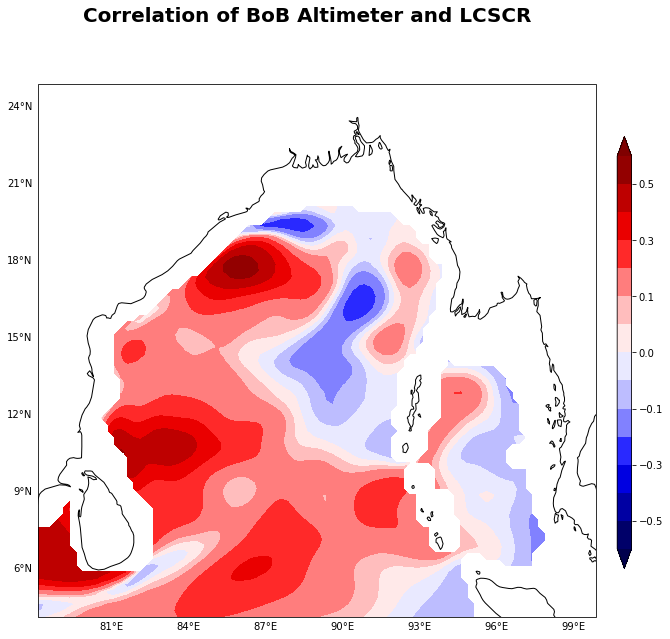

In [641]:
plot(corr_altimter_lcs,'Correlation of BoB Altimeter and LCSCR',
    'corr_altimter_lcs.jpg')

## Correlation of BoB Altimeter low and LCSCR low

In [618]:
## first we need to make the model data as altimeter data
BoB_lcs_low_inp1 = BoB_lcs_low1.interp_like(BoB_altimeter_low1)
BoB_lcs_low_inp1=BoB_lcs_low_inp1.interp(latitude=BoB_altimeter_low1.latitude, 
                                       longitude=BoB_altimeter_low1.longitude)



In [619]:
corr_altimter_lcs_low=xr.corr(BoB_altimeter_low1,BoB_lcs_low_inp1,dim='time')

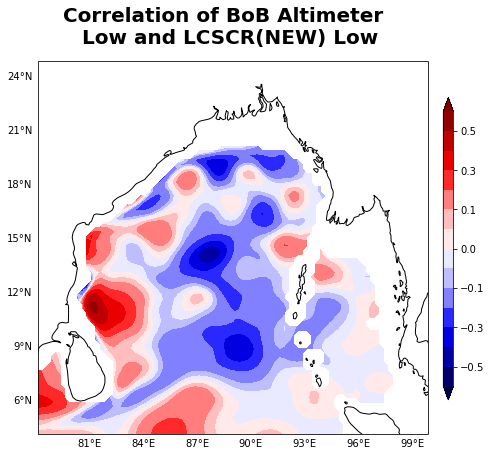

In [651]:
plot(corr_altimter_lcs_low,'Correlation of BoB Altimeter \n Low and LCSCR(NEW) Low',
    'corr_altimter_lcs_low.jpg')

## Correlation of BoB Altimeter low and LCSCR(OLD) low

In [628]:
## first we need to make the model data as altimeter data
BoB_lcs_low_old_inp1 = BoB_lcs_low_old1.interp_like(BoB_altimeter_low1)
BoB_lcs_low_old_inp1=BoB_lcs_low_old_inp1.interp(latitude=BoB_altimeter_low1.latitude, 
                                       longitude=BoB_altimeter_low1.longitude)

BoB_lcs_low_old_inp1=BoB_lcs_low_old_inp1.drop('ZAXIS1_1')

In [629]:
corr_altimter_lcs_old_low=xr.corr(BoB_altimeter_low1,BoB_lcs_low_old_inp1,dim='time')

In [ ]:
plot()

/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


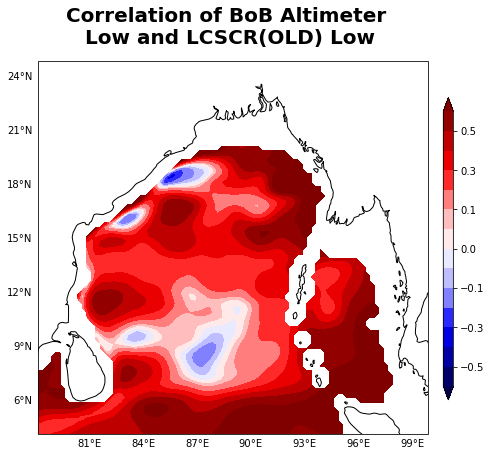

In [652]:
plot(corr_altimter_lcs_old_low,'Correlation of BoB Altimeter\n Low and LCSCR(OLD) Low',
    'corr_altimter_lcs_low_old.jpg')

## The difference

In [637]:
diff=corr_altimter_lcs_old_low-corr_altimter_lcs_low

/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


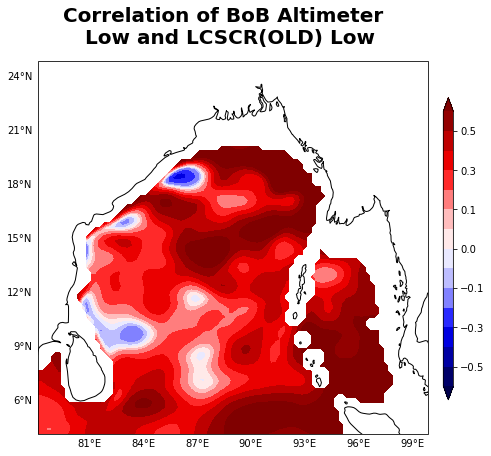

In [654]:
plot(diff,'Correlation of BoB Altimeter \n Low and LCSCR(OLD) Low',
    'corr_diff.jpg')

# Point checking 

In [229]:
x1,y1=15,84
x2,y2=17.5,86

In [534]:
BoB_altimeter

<xarray.DataArray 'sla' (time: 9672, latitude: 84, longitude: 88)>
dask.array<getitem, shape=(9672, 84, 88), dtype=float64, chunksize=(9672, 84, 88), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-30
  * longitude  (longitude) float32 78.12 78.38 78.62 78.88 ... 99.38 99.62 99.88
  * latitude   (latitude) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88

In [685]:
input_data=BoB_altimeter_low
input_data=input_data.sel(time=slice('2001-01-01','2004-01-01'))
p1_alt=input_data.sel(latitude=slice(11,12),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p2_alt=input_data.sel(latitude=slice(14,15),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p3_alt=input_data.sel(latitude=slice(17,18),longitude=slice(86,87)).mean(dim='latitude').mean(dim='longitude')

In [686]:
input_data=BoB_lcs_low
input_data=input_data.sel(time=slice('2001-01-01','2004-01-01'))
p1_lcs=input_data.sel(latitude=slice(11,12),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p2_lcs=input_data.sel(latitude=slice(14,15),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p3_lcs=input_data.sel(latitude=slice(17,18),longitude=slice(86,87)).mean(dim='latitude').mean(dim='longitude')

In [687]:
input_data=BoB_lcs_low_old
input_data=input_data.sel(time=slice('2001-01-01','2004-01-01'))
p1_lcs_old=input_data.sel(latitude=slice(11,12),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p2_lcs_old=input_data.sel(latitude=slice(14,15),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p3_lcs_old=input_data.sel(latitude=slice(17,18),longitude=slice(86,87)).mean(dim='latitude').mean(dim='longitude')

In [688]:
print(p1_alt.shape)
p1_lcs.shape

(1075,)


(1096,)

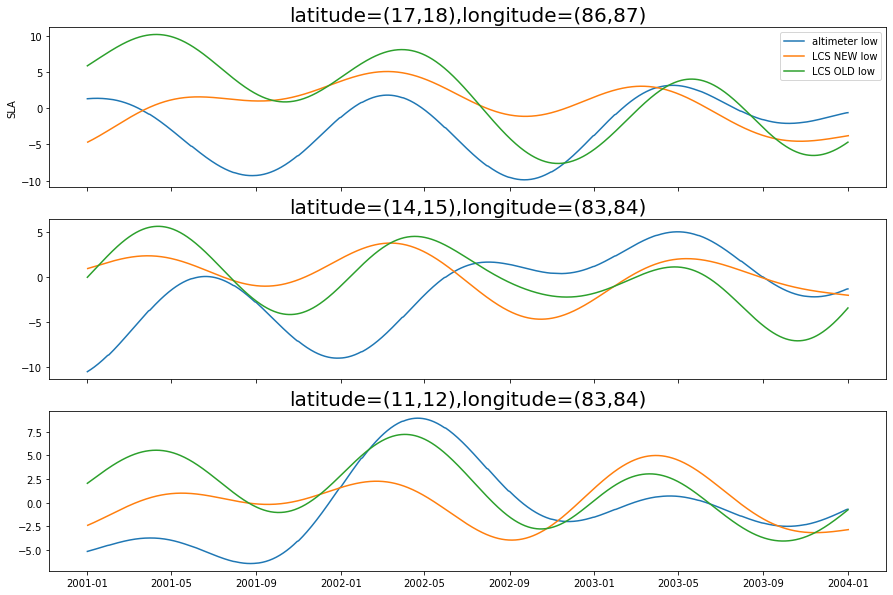

In [726]:
fig, ax = plt.subplots(3, 1, sharex=True,figsize=(15,10))
ax[0].plot(p3_alt.coords["time"], p3_alt)
ax[0].plot(p3_lcs.coords["time"], p3_lcs)
ax[0].plot(p3_lcs_old.coords["time"], p3_lcs_old)
ax[0].set_title('latitude=(17,18),longitude=(86,87)',fontsize=20)
ax[0].set_ylabel("SLA");
ax[0].legend(['altimeter low','LCS NEW low','LCS OLD low']);

ax[1].plot(p2_alt.coords["time"], p2_alt)
ax[1].plot(p2_lcs.coords["time"], p2_lcs)
ax[1].plot(p2_lcs_old.coords["time"], p2_lcs_old)
ax[1].set_title('latitude=(14,15),longitude=(83,84)',fontsize=20)

ax[2].plot(p1_alt.coords["time"], p1_alt)
ax[2].plot(p1_lcs.coords["time"], p1_lcs)
ax[2].plot(p1_lcs_old.coords["time"], p1_lcs_old)
ax[2].set_title('latitude=(11,12),longitude=(83,84)',fontsize=20)
plt.savefig('comp.jpg',dpi=130)


# Analysis with the altimeter 

## Decadal change

In [95]:
BoB_altimeter_low_clim_99_09 = BoB_altimeter_low.sel(time=slice(
    '1999-01-01','2009-12-30')).groupby(
    'time.month').mean(dim='time')

In [188]:
BoB_altimeter_low_clim_10_19 = BoB_altimeter_low.sel(time=slice(
    '2009-01-01','2019-12-30')).groupby(
    'time.month').mean(dim='time')

### Summer

In [189]:
a=BoB_altimeter_low_clim_99_09
summer_99_09_clim=a.sel(month=slice(6,8)).mean(dim='month')  

b=BoB_altimeter_low_clim_10_19
summer_10_19_clim=b.sel(month=slice(6,8)).mean(dim='month') 

summer_diff=summer_10_19_clim-summer_99_09_clim

### Spring

In [190]:
a=BoB_altimeter_low_clim_99_09
spring_99_09_clim=a.sel(month=slice(3,5)).mean(dim='month')  

b=BoB_altimeter_low_clim_10_19
spring_10_19_clim=b.sel(month=slice(3,5)).mean(dim='month')   

spring_diff=spring_10_19_clim-spring_99_09_clim

### Winter

In [191]:
a=BoB_altimeter_low_clim_99_09
winter_99_09_clim=a.sel(month=[12,1,2]).mean(dim='month')  

b=BoB_altimeter_low_clim_10_19
winter_10_19_clim=b.sel(month=[12,1,2]).mean(dim='month') 

winter_diff=winter_10_19_clim-winter_99_09_clim

## Plotting

In [192]:
def plot(input_data,title,output):

##########  Plotting ###########
    fig, axs = plt.subplots(nrows=3,ncols=3,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,12))
    axs=axs.flatten()
    y_label=set([0,3,6])
    x_label=set([6,7,8])
    L2=[-5,-4,-3,-2,-1,0,1,2,3,4,5]
    datasets=input_data
    for i,year in enumerate(datasets):
            data=datasets[year]
            cs=axs[i].contourf(data.longitude,data.latitude,data,
                              levels=L2,transform = ccrs.PlateCarree(),
                              cmap='seismic',extend='both')
            axs[i].set_extent([78,100,4,25])
            axs[i].set_title(year,fontsize = 15, weight='bold')
            axs[i].coastlines()
            if i in y_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                #gl.xlines=False
            if i in x_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
           
    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)
    plt.suptitle(title,fontsize = 30,weight='bold')
    plt.savefig(output,dpi=120)
    
    return 

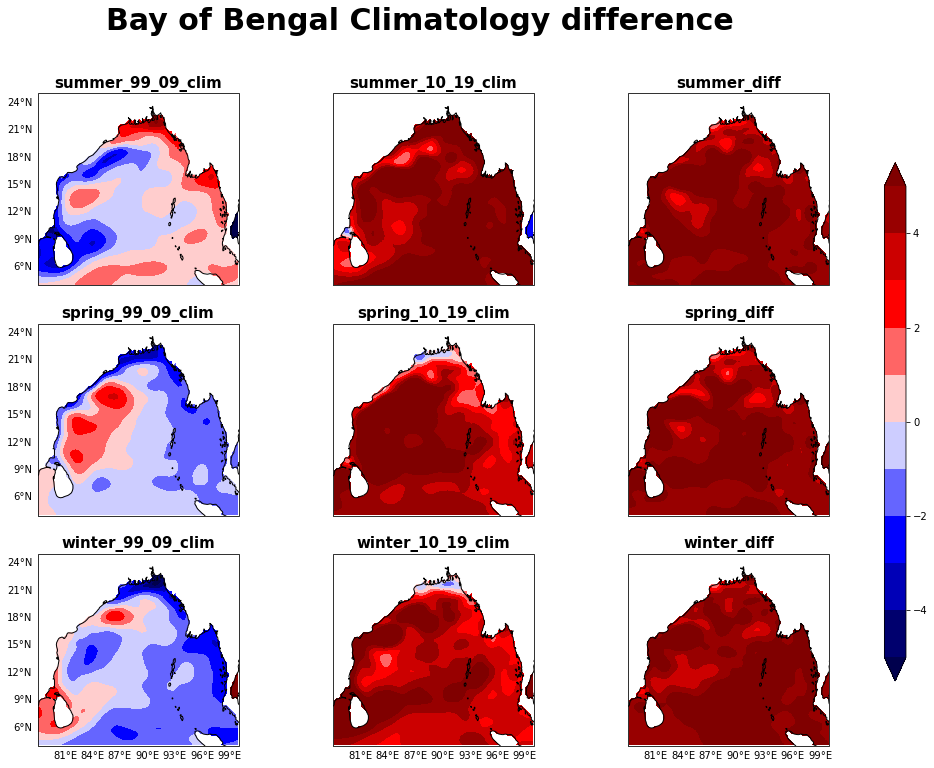

In [193]:
datasets={}
datasets=dict({'summer_99_09_clim':summer_99_09_clim,
           'summer_10_19_clim':summer_10_19_clim,
           'summer_diff':summer_diff,
           'spring_99_09_clim':spring_99_09_clim,
           'spring_10_19_clim':spring_10_19_clim,
           'spring_diff':spring_diff,
           'winter_99_09_clim':winter_99_09_clim,
           'winter_10_19_clim':winter_10_19_clim,
           'winter_diff':winter_diff,
          })
plot(datasets,'Bay of Bengal Climatology difference','BoB_clim_diff.jpg')

In [186]:
input_data=BoB_altimeter_low
df=[]
for i in range(2009,2019):
        summer_unfiltered=input_data.sel(time=slice(repr(i)+'-06-01',repr(i)+'-08-31')).mean(dim='time')
        df.append(summer_unfiltered)

In [187]:
total=df[0]
for i in range(1,len(df)):
    print(i)
    total=total+df[i]
    

1
2
3
4
5
6
7
8
9


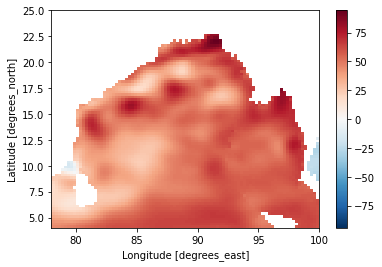

In [160]:
total.plot()